In [1]:
import sys

from FileTools import FileTools
# from pprint import pprint
from pathlib import Path
from zipfile import ZipFile
import pickle
#import random
import json
import time
import os

from matplotlib import pyplot as plt
#import seaborn as sns
import pandas as pd
import numpy as np
import math
import re

from kaggle.api.kaggle_api_extended import KaggleApi

In [2]:
# authenticate with API

currWorkDir = os.getcwd()
userDir = Path.home()
keyPath = f"{userDir}\\PYC\\ADMIN\\kaggle.json"

with open( keyPath, 'r' ) as f: keyDict = json.load( f )
userTitle, keyTitle = keyDict.keys()
kaggleUsername, kaggleKey = keyDict[ userTitle ], keyDict[ keyTitle ]

os.environ[ 'KAGGLE_USERNAME' ] = kaggleUsername
os.environ[ 'KAGGLE_KEY' ] = kaggleKey

api = KaggleApi()
api.authenticate()


In [3]:
# retrieve dataset
datasetOwner = 'lucafrance'
datasetName = 'the-world-factbook-by-cia'
api.dataset_download_files( f'{datasetOwner}/{datasetName}', path="." )

# await download
fTools = FileTools()
datasetFName = None
print( "Waiting for dataset download" )
while True:
    time.sleep( 1 )
    sortedFs = fTools.datesortFiles( currWorkDir, datasetName )
    if len( sortedFs ) == 0: continue
    datasetFName = list( sortedFs )[ 0 ]
    print( f"Latest: {datasetFName}" )
    break

Waiting for dataset download
Latest: the-world-factbook-by-cia.zip


In [4]:
# extract and identify datafiles

origDataDir = f"{currWorkDir}\\data_or"
if not os.path.exists( origDataDir ): os.makedirs( origDataDir )

if datasetFName and Path( datasetFName ).suffix == ".zip":
    with ZipFile( datasetFName, 'r' ) as zipF: zipF.extractall( origDataDir )

dataPaths = [ f"{origDataDir}\\{pth}" for pth in os.listdir( origDataDir )
    if Path( pth ).suffix == ".csv" ]

if len( dataPaths )>0:
    dffBook = pd.read_csv( [ pth for pth in dataPaths ][ 0 ] )
    print( "Got dffBook DF from extracted dataset at:\n", dataPaths[ 0 ] )
else: print( "Failed get CSV" ); sys.exit()

dffBook

Got dffBook DF from extracted dataset at:
 C:\Users\romstroller\PYC\ciaFactBook\data_or\countries.csv


,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,https://www.cia.gov/the-world-factbook/countri...,Ahmad Shah DURRANI unified the Pashtun tribes ...,"Southern Asia, north and west of Pakistan, eas...","33 00 N, 65 00 E",Asia,"652,230 sq km","652,230 sq km",0 sq km,almost six times the size of Virginia; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,https://www.cia.gov/the-world-factbook/countri...,By terms of the 1960 Treaty of Establishment t...,"Eastern Mediterranean, peninsula on the southw...","34 37 N, 32 58 E",Middle East,123 sq km,NaN,NaN,"about 0.7 times the size of Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,https://www.cia.gov/the-world-factbook/countri...,Albania declared its independence from the Ott...,"Southeastern Europe, bordering the Adriatic Se...","41 00 N, 20 00 E",Europe,"28,748 sq km","27,398 sq km","1,350 sq km",slightly smaller than Maryland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,https://www.cia.gov/the-world-factbook/countri...,Algeria has known many empires and dynasties s...,"Northern Africa, bordering the Mediterranean S...","28 00 N, 3 00 E",Africa,"2,381,740 sq km","2,381,740 sq km",0 sq km,slightly less than 3.5 times the size of Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,https://www.cia.gov/the-world-factbook/countri...,Tutuila was settled by 1000 B.C. and the islan...,"Oceania, group of islands in the South Pacific...","14 20 S, 170 00 W",Oceania,224 sq km,224 sq km,0 sq km,"slightly larger than Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,https://www.cia.gov/the-world-factbook/countri...,The landlocked West Bank - the larger of the t...,"Middle East, west of Jordan, east of Israel","32 00 N, 35 15 E",Middle East,"5,860 sq km","5,640 sq km",220 sq km,slightly smaller than Delaware,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,World,https://www.cia.gov/the-world-factbook/countri...,"Globally, the 20th century was marked by: (a) ...",NaN,NaN,Physical Map of the World,510.072 million sq km,148.94 million sq km,361.9 million sq km,land area about 16 times the size of the US,...,there are 20 countries without rivers: 3 in Af...,"Caspian Sea (Azerbaijan, Iran, Kazakhstan, Rus...","the deepest lake in the world (1,620 m), and a...","Shanghai (China) - 43,303,000; Singapore (Sing...",the UN High Commissioner for Refugees (UNHCR) ...,"(44 countries) Armenia, Aruba, Azerbaijan, Bar...","(19 countries) Afghanistan, Algeria, Belarus, ...",worldwide coca cultivation in 2020 likely amou...,worldwide illicit opium poppy cultivation prob...,NaN
255,Yemen,https://www.cia.gov/the-world-factbook/countri...,The Kingdom of Yemen (colloquially known as No...,"Middle East, bordering the Arabian Sea, Gulf o...","15 00 N, 48 00 E",Middle East,"527,968 sq km","527,968 sq km",0 sq km,almost four times the size of Alabama; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16 million (2019)
256,Zambia,https://www.cia.gov/the-world-factbook/countri...,Multiple waves of Bantu-speaking groups moved ...,"Southern Africa, east of Angola, south of 

In [5]:
# Analyse cell data for numbers and units

def matchNumbers( df_in, coIdex, patrn ):
    # get any number-pattern match from each row in a list
    return df_in.iloc[ :, coIdex ].str.findall( patrn )


def getRemainder( df_in, coIdex, pattrn ):
    # store non-number remainder of string (potential unit etc)
    return df_in.iloc[ :, coIdex ].str.replace( pattrn, '' )


# MATCHING NUMBERS
# REGEX:
#   capture group             (                 
#   zero/one                  [+-]?             possible number sign
#   1-3 nums                  \d{1,3}           up to three straight nums
#   non-capture subgroup      (?:               possible thousand-groups
#     comma and 3 nums          ,\d{3}          (sep. comma)
#     zero or more times        )*              
#   non-capture subgroup      (?:               then possible decimal part
#     decimal and 1+nums        \.\d+           
#     zero/one time             )?            
#   OR (alt. to last seq)     |                 or no groups, just              
#     0+ nums, dec, 1+nums      \d*\.\d+        more nums and poss decimal
#   OR (alt. to last seq)     |             
#     1+ nums                   \d+             or just more numbers.
#   Close capture group       )
#   ( match basic number last to capture greatest valid str segment )

patt = re.compile( r'([+-]?\d{1,3}(?:,\d{3})*(?:\.\d+)?|\d*\.\d+|\d+)' )

dfFbDict = { }  # to collect column data during cleaning
checkTypes = { }
colDex = 1
for colName in dffBook.columns[ colDex: ]:
    origCol = dffBook.iloc[ :, colDex ]
    # get match if string, store if already float, catch unexpected
    if type( origCol[ 0 ] ) == str: colDict = {
        'matchedNums': matchNumbers( dffBook, colDex, patt ),
        'remainder': getRemainder( dffBook, colDex, patt ) }
    elif type( origCol[ 0 ] ) == np.float64: colDict = {
        'matchedNums': origCol.astype( float ), 'remainder': [ ] }
    elif type( origCol[ 0 ] ) != float:
        checkTypes[ type( origCol[ 0 ] ) ] = colDex
        colDict = { 'matchedNums': origCol, 'remainder': [ ] }
    else: colDict = {
        'matchedNums': matchNumbers( dffBook, colDex, patt ),
        'remainder': getRemainder( dffBook, colDex, patt ) }
    colDict[ 'origCol' ] = origCol
    dfFbDict[ colName ] = colDict
    colDex += 1

for i in checkTypes: print( f"unexpected: {i} at {checkTypes[ i ]}" )


In [6]:
# split first match item from list as float to "clean", store else to "split"
def splitFirstOther( matchList ):
    firstVals, splitVals, checkVals = [ ], [ ], [ ]
    for mNum in range( len( matchList ) ):
        el = matchList[ mNum ]
        isFilldList = (type( el ) == list) and (len( el )>0)
        if isFilldList:  # remove any thousandcomma to support convert
            firstVals.append( float( ''.join( el[ 0 ].split( ',' ) ) ) )
            splitVals.append( [ v for v in el[ 1: ] ] )
        else:  # check all else are either nan or empty matchlist
            if ((type( el ) == list and len( el )>0) or
                (type( el ) != list and math.isnan( el ) == False)):
                checkVals.append( el )
            firstVals.append( np.nan )
            splitVals.append( np.nan )
    return firstVals, splitVals, checkVals


for colName in dfFbDict:
    colDict = dfFbDict[ colName ]
    colDict[ 'clean' ], colDict[ 'splitVals' ], colDict[ 'checkVals' ] = (
        splitFirstOther( colDict[ 'matchedNums' ] ))

# Raise message if got uncategorized data
for colName in dfFbDict:
    if len( dfFbDict[ colName ][ 'checkVals' ] )>0:
        print( f"Got checkvals for {colName}" )

Got checkvals for People and Society: Dependency ratios - total dependency ratio
Got checkvals for People and Society: Dependency ratios - youth dependency ratio
Got checkvals for People and Society: Dependency ratios - elderly dependency ratio
Got checkvals for Transportation: Airports - with unpaved runways - over 3,047 m
Got checkvals for Geography: Land boundaries - metropolitan France - total
Got checkvals for Geography: Land boundaries - French Guiana - total


In [7]:
# dictionary columns to DF, checking is now float
newCols = [ ]
dfFloat = dffBook.iloc[ :, 0 ]  # start with countries
for colName in dfFbDict:
    clean = pd.Series( dfFbDict[ colName ][ 'clean' ] )
    lenFloat = len( [ i for i in clean if type( i ) == float ] )
    if lenFloat>len( clean ) * 0.90:
        newCols.append( colName )
        dfFloat = pd.concat( [ dfFloat, clean ], axis=1 )
    else: print( "col is less than 90% float. Dropping..." )

dfFloat.columns = [ 'Country' ] + newCols
dfFloat


,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,NaN,174.0,NaN,33.0,NaN,652230.000,652230.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,NaN,196.0,NaN,34.0,NaN,123.000,NaN,NaN,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,NaN,191.0,NaN,41.0,NaN,28748.000,27398.00,1350.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,NaN,3.0,NaN,28.0,NaN,2381740.000,2381740.00,0.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,NaN,100.0,NaN,14.0,NaN,224.000,224.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,NaN,15.0,NaN,32.0,NaN,5860.000,5640.00,220.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,World,NaN,20.0,NaN,NaN,NaN,510.072,148.94,361.9,16.0,...,20.0,372960.0,1620.0,43303000.0,202.0,44.0,19.0,202.0,265000.0,NaN
255,Yemen,NaN,191.0,NaN,15.0,NaN,527968.000,527968.00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
256,Zambia,NaN,188.0,NaN,15.0,NaN,752618.000,743398.00,9220.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Enforce non-nan threshold for dimensions

def nanThreshold( notNan ):  # average plus .5 standard deviation (rounded)
    return int( (sum( notNan ) / len( notNan )) + 0.5 * np.std( notNan ) )


def nonNanFromDims( dfr, dim = 1 ):
    nonNans = [ ]
    for pos in range( 0, dfr.shape[ dim ] ):
        if dim == 1: vals = dfr.iloc[ :, pos ].tolist()
        else: vals = dfr.loc[ [ pos ] ].values.tolist()[ 0 ]
        
        nonNans.append( [ vals, len( [ v for v in vals if
            type( v ) == float and not math.isnan( v ) ] ) ] )
    
    _thresh = nanThreshold( [ nval for _, nval in nonNans ] )
    keepVals = [ kval for kval, nnul in nonNans if nnul>=_thresh ]
    print( f"non-nan[ {len( keepVals )} ] thr[ {_thresh} ] dim[ {dim} ]" )
    
    return keepVals

In [9]:
# DROP ROWS - disabled to keep all significant countries
def cleanRows():
    dfClean = pd.DataFrame( nonNanFromDims( dfFloat, dim=0 ) )
    # add a columnindex row to track names of kept columns
    dfClean.loc[ -1 ] = dfFloat.columns
    dfClean.index = dfClean.index + 1
    dfClean.sort_index( inplace=True )
    return dfClean

# dfRowsClean = cleanRows()
# keepCols_RC = nonNanFromDims( dfRowsClean, dim=1 )
# # convert to numeric df - row-cleaned
# dfRCC = pd.DataFrame( { col[ 0 ]: col[ 1: ] for col in keepCols_RC } )
# dfRCC = dfRCC.apply( pd.to_numeric, errors='ignore' )
# dfColsClean = dfRCC

In [10]:
# CLEAN COLS to numeric, adding featname row for tracking through clean
dfFloat.loc[ -1 ] = dfFloat.columns
dfFloat.index = dfFloat.index + 1
dfFloat.sort_index( inplace=True )
keepCols = nonNanFromDims( dfFloat, dim=1 )
dfColsClean = pd.DataFrame( { col[ 0 ]: col[ 1: ] for col in keepCols } )
dfColsClean = dfColsClean.apply( pd.to_numeric, errors='ignore' )
dfColsClean.insert( 0, 'Country', dfFloat.iloc[ :, 0 ].tolist()[ 1: ] )
dfColsClean

non-nan[ 261 ] thr[ 97 ] dim[ 1 ]


,Country,Introduction: Background,Geography: Geographic coordinates,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,...,Economy: Credit ratings - Moody's rating,Economy: Credit ratings - Standard & Poors rating,Communications: Telecommunication systems - note,Transportation: Railways - total,Transportation: Merchant marine - total,Transportation: Merchant marine - by type,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled,Geography: Maritime claims - exclusive economic zone,Economy: Credit ratings - Fitch rating
0,Afghanistan,174.0,33.0,652230.000,652230.00,0.0,5987.00,0.0,7492.0,258.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,196.0,34.0,123.000,NaN,NaN,48.00,56.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,191.0,41.0,28748.000,27398.00,1350.0,691.00,362.0,2764.0,0.0,...,1.0,201.0,-19.0,677.0,70.0,47.0,NaN,NaN,NaN,NaN
3,Algeria,3.0,28.0,2381740.000,2381740.00,0.0,6734.00,998.0,2908.0,-40.0,...,NaN,NaN,-19.0,3973.0,114.0,1.0,990299.0,8.0,NaN,NaN
4,American Samoa,100.0,14.0,224.000,224.00,0.0,0.00,116.0,964.0,0.0,...,NaN,NaN,-19.0,NaN,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,15.0,32.0,5860.000,5640.00,220.0,478.00,0.0,1020.0,-431.0,...,NaN,NaN,-19.0,NaN,NaN,NaN,6935.0,0.5,NaN,NaN
254,World,20.0,NaN,510.072,148.94,361.9,NaN,356000.0,8849.0,-3500.0,...,NaN,NaN,NaN,1148186.0,98202.0,12319.0,NaN,NaN,NaN,NaN
255,Yemen,191.0,15.0,527968.000,527968.00,0.0,1601.00,1906.0,3666.0,0.0,...,NaN,NaN,-19.0,NaN,34.0,2.0,386946.0,8.0,200.0,NaN
256,Zambia,188.0,15.0,752618.000,743398.00,9220.0,6043.15,0.0,2330.0,329.0,...,202.0,202.0,-19.0,3126.0,2.0,1.0,NaN,NaN,NaN,202.0


In [11]:
# Review clean DF
fbIsNa = dffBook.isna().sum().sum()
dfIsNa = dfColsClean.isna().sum().sum()
fbDim = dffBook.shape[ 0 ] * dffBook.shape[ 1 ]
dfDim = dfColsClean.shape[ 0 ] * dfColsClean.shape[ 1 ]
print( f"factbook originally shape: {dffBook.shape}" )
print( f"    NAN-density: {(fbIsNa / fbDim):.2f}% "
       f"({fbIsNa} NaN in {fbDim})" )
print( f"clean dataframe has shape: {dfColsClean.shape}" )
print( f"    NAN-density: {(dfIsNa / dfDim):.2f}% "
       f"({dfIsNa} NaN in {dfDim})" )

factbook originally shape: (258, 1054)
    NAN-density: 0.74% (200708 NaN in 271932)
clean dataframe has shape: (258, 262)
    NAN-density: 0.22% (15078 NaN in 67596)


In [12]:
# Reporting to identify any differences of unit scale within features

In [13]:
# Add some further cleaning to remainder to reduce non-unit variations

def cleanRemainder():
    cleanPatts = [
        r'(\([^)]*\))',  # remove all bracketed
        r'(.* m)$|(.* m) '  # remove all before " m[endline/space]" (mtn names)
        ]
    
    cleanReman = { }
    
    for col in list( dfFloat.columns )[ 1: ]:
        remainder = dfFbDict[ col ][ 'remainder' ]
        for pattStr in cleanPatts:
            pattrn = re.compile( pattStr )
            remainder = remainder.str.replace( pattrn, '' )
        cleanReman.update( { colName: remainder } )
    
    return cleanReman

# cleanReman = cleanRemainder()

In [14]:
# CHECK FOR SCALE FACTORS /GENERAL FEATURE ANALYSIS/SELECTIOn

def runScaleAnalysis( dfr, remDict ):
    colList = list( dfr.columns )
    dropFeatrs = [ ]
    cleanNotes = { }
    
    for pos in range( 1, len( colList ) ):
        colNam = colList[ pos ]
        colSeg = dfr.iloc[ :, pos ].tolist()[ :10 ]
        remndr = set( remDict[ colNam ] )
        rMainPrint = ""
        for r in list( remndr )[ :25 ]:
            if type( r ) == float: rMainPrint = rMainPrint + f"{r}\n"
            else: rMainPrint = rMainPrint + f"{r[ :60 ]}\n"
        
        report = (f"COL [ {pos} ] {colNam}\n\n"
                  f"CLEANVALS:\n{colSeg}\n\n"
                  f"REMAINDER (unq in col: {len( remndr )}):\n{rMainPrint}\n")
        
        report_a = report + "\nACCEPT(A), BREAK(B), CLEAN/SCALE NOTE(C), DROP(D)"
        report_b = report_a + "\n\nPLEASE MAKE A SELECTION:\n\n"
        usinp = input( report_a )
        while usinp not in [ 'a', 'd', 'c', 'b' ]: usinp = input( report_b )
        if usinp == 'b': break
        elif usinp == 'a': continue
        elif usinp == 'd': dropFeatrs.append( colNam )
        else: cleanNotes.update( {
            colNam: input( f"{report[ :250 ]}...\n\n\nCLEANING/SCALE NOTE" ) } )
    
    return dropFeatrs, cleanNotes

# dropFeatrs, cleanNotes = runScaleAnalysis(dfColsClean, cleanReman)

In [15]:
# # SAVE SCALE ANALYSIS DATA
# stmp = fTools.dtStamp()
# fTools.storePKL( dropFeatrs, f'dropFeatrs_{stmp}', currWorkDir, subdir=None )
# fTools.storePKL( cleanNotes, f'cleanNotes_{stmp}', currWorkDir, subdir=None )

In [16]:
# LOAD SCALE ANALYSIS DATA
pklFiles = [ fi for fi in
    [ open( pth, 'rb' ) for pth in
        [ list( dKey )[ 0 ] for dKey in
            [ fTools.datesortFiles( currWorkDir, fNam ) for fNam in
                [ 'dropFeatrs', 'cleanNotes' ] ] ] ] ]

dropFeats, scaleNotes = [ pickle.load( fi ) for fi in pklFiles ]
for fi in pklFiles: fi.close()

In [17]:
df = dfColsClean.copy()
for i in dropFeats:
    try: df.drop( [ i ], axis=1, inplace=True )
    except KeyError: pass
scaleKeys = [ dkey for dkey in scaleNotes if dkey not in dropFeats ]

In [18]:
# update value by matching remainder scale fragment via country reference

dct = dfFbDict.copy()

scaleDict = {
    "million": 1000000,
    "billion": 1000000000,
    "trillion": 1000000000000 }

cleanCountries = list( df[ 'Country' ] )

for colName in scaleKeys:
    colVals = [ ]
    row = 0
    
    # checking remnantcol (HAS PRE-CLEAN ENTRIES) for match
    for remnt in dct[ colName ][ 'remainder' ]:
        country = dffBook[ 'Country' ][ row ]
        if country not in cleanCountries: row += 1; continue
        val = df.loc[ df[ 'Country' ] == country ][ colName ].iloc[ 0 ]
        if type( remnt ) == float: row += 1; colVals.append( val ); continue
        if remnt.startswith( "-$" ): val = 0 - val  # fix $ breaking neg float
        
        matches = [ ]
        for scale in scaleDict:  # apply lowest-index matched scale
            try: matches.append( [ remnt.index( scale ), scale ] )
            except ValueError: continue
        if len( matches )>0:  # sort by lowest index (first val of match)
            matchScale = sorted( matches, key=lambda x: x[ 0 ] )[ 0 ][ 1 ]
            val = val * scaleDict[ matchScale ]
        
        colVals.append( val )
        row += 1
    
    df[ colName ] = colVals

pd.options.display.float_format = '{:,.2f}'.format
df


,Country,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Land boundaries - total,Geography: Coastline,Geography: Elevation - highest point,Geography: Elevation - lowest point,Geography: Elevation - mean elevation,Geography: Land use - agricultural land,...,Transportation: Heliports,Transportation: Roadways - total,Transportation: Roadways - paved,Transportation: Roadways - unpaved,Military and Security: Military expenditures,Military and Security: Military and security service personnel strengths,Transportation: Railways - total,Transportation: Merchant marine - total,Environment: Waste and recycling - municipal solid waste recycled annually,Environment: Waste and recycling - percent of municipal solid waste recycled
0,Afghanistan,"652,230.00","652,230.00",0.00,"5,987.00",0.00,"7,492.00",258.00,"1,884.00",58.10,...,1.00,"34,903.00","17,903.00","17,000.00",3.30,"58,000.00",NaN,NaN,NaN,NaN
1,Akrotiri,123.00,NaN,NaN,48.00,56.30,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,"28,748.00","27,398.00","1,350.00",691.00,362.00,"2,764.00",0.00,708.00,42.80,...,NaN,"3,945.00",NaN,NaN,1.40,"8,000.00",677.00,70.00,NaN,NaN
3,Algeria,"2,381,740.00","2,381,740.00",0.00,"6,734.00",998.00,"2,908.00",-40.00,800.00,17.40,...,4.00,"104,000.00","71,656.00","32,344.00",5.60,"140,000.00","3,973.00",114.00,"990,299.00",8.00
4,American Samoa,224.00,224.00,0.00,0.00,116.00,964.00,0.00,NaN,24.50,...,NaN,241.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,West Bank,"5,860.00","5,640.00",220.00,478.00,0.00,"1,020.00",-431.00,NaN,43.30,...,1.00,"4,686.00","4,686.00",NaN,NaN,"30,000.00",NaN,NaN,"6,935.00",0.50
254,World,"510,072,000.00","148,940,000.00","361,900,000.00",NaN,"356,000.00","8,849.00","-3,500.00",840.00,NaN,...,"6,524.00",NaN,NaN,NaN,2.40,20.00,"1,148,186.00","98,202.00",NaN,NaN
255,Yemen,"527,968.00","527,968.00",0.00,"1,601.00","1,906.00","3,666.00",0.00,999.00,44.50,...,NaN,"71,300.00","6,200.00","65,100.00",4.00,"300,000.00",NaN,34.00,"386,946.00",8.00
256,Zambia,"752,618.00","743,398.00","9,220.00","6,043.15",0.00,"2,330.00",329.00,"1,138.00",31.70,...,NaN,"67,671.00","14,888.00","52,783.00",1.30,"17,000.00","3,126.00",2.00,NaN,NaN


In [19]:
# a few top/bottom-tens

# remove "World" until needed
dfWorld = df[ df.Country == 'World' ].copy()
df = df[ df.Country != 'World' ].copy()

In [20]:
# need to go back and get units
def showTopTen( featName, _df, asc = False ):
    print( featName )
    
    df10 = pd.concat( [ _df[ 'Country' ],
        pd.Series( _df[ featName ] ) ], axis=1 ).sort_values( by=[ featName ],
        ascending=asc )[ :10 ]
    
    fig = plt.figure()
    fig.suptitle( f"{'BOTTOM' if asc else 'TOP'} TEN\n{featName}", fontsize=10 )
    
    ax = fig.add_axes( [ 0, 0, 1, 1 ] )
    ax.bar( df10.iloc[ :, 0 ], df10.iloc[ :, 1 ] )
    ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )
    ax.ticklabel_format( axis='y', useOffset=False, style='plain' )
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize( 14 )
    plt.show()


Geography: Area - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


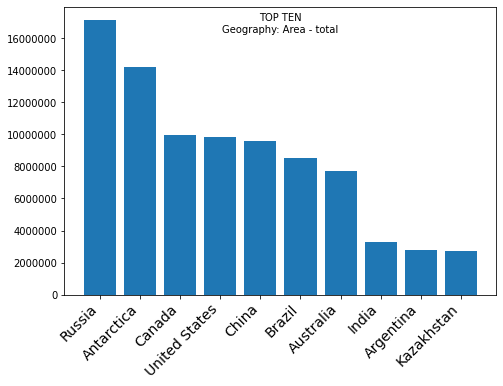

In [21]:
# largest countries. 
showTopTen( 'Geography: Area - total', df )
# Some thoughts:
#   The invasion of Ukraine should not be considered an act of 
#       ordinary claustrophobia
#   Antarctica: what is it good for?
#   Looking at sovereign territories as real-estate for future resources [..]
#   ...


Water-area ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


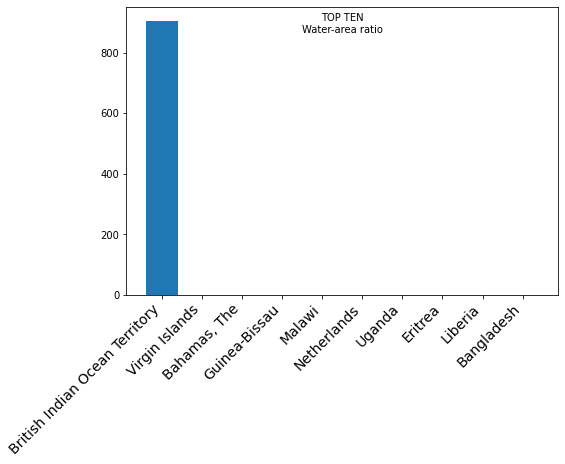

In [22]:

# highest percent water area
df[ 'Water-area ratio' ] = (
    df[ 'Geography: Area - water' ] /
    df[ 'Geography: Area - total' ])
showTopTen( 'Water-area ratio', df )
# The British Indian Ocean territory data here is an outlier arising from an
#   apparent inconsistency or ambiguity in geographic description - 
#   the territory is designated across a very sparse grouping of islands which 
#   are themselves thin segments of atolls or whole/partial atolls with large 
#   inner bodies of water. Some interesting reading both for observers of 
#   colonialism and for ongoing events in the projection of sovereign power 
#   across large sea vectors:

#### British Indian Ocean Territory
![British_Indian_Ocean_Territory](https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/British_Indian_Ocean_Territory_in_United_Kingdom.svg/1466px-British_Indian_Ocean_Territory_in_United_Kingdom.svg.png)

WIKI: 
>The only inhabitants are British and U.S. military personnel and associated 
contractors, who collectively number around 3,000 (2018 figures). The 
forced removal of Chagossians from the Chagos Archipelago occurred between 
1968 and 1973. [...] Today, the exiled Chagossians are still trying 
to return, saying that the forced expulsion and dispossession was unlawful, 
but the UK government has repeatedly denied them the right of return. The 
islands are off-limits to Chagossians, casual tourists, and the media. 



Water-area ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


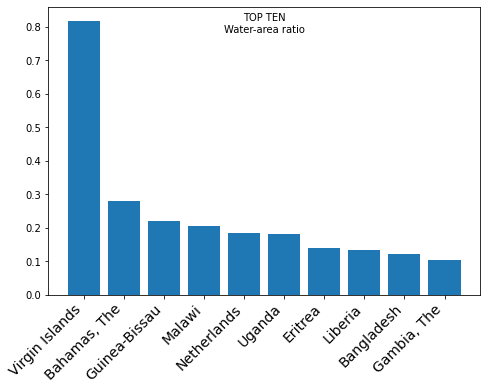

In [23]:
# Excluding it as an outlier reveals a more intuitive distribution.
showTopTen( 'Water-area ratio',
    df[ df.Country != 'British Indian Ocean Territory' ] )


Geography: Coastline


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


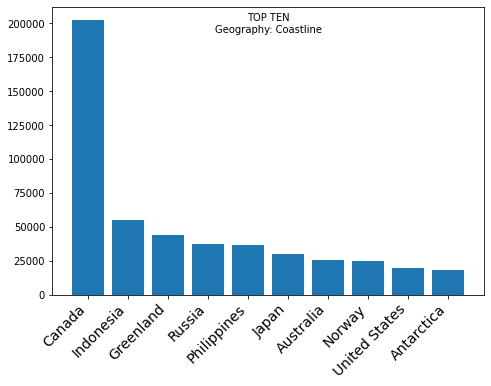

In [24]:
# It should be safe to posit that Canada is likely at least somewhat well-known 
# as a destination for those people with metal detectors you always see a few 
# hundred meters away at the beach.
showTopTen( 'Geography: Coastline', df )

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


Elevation difference


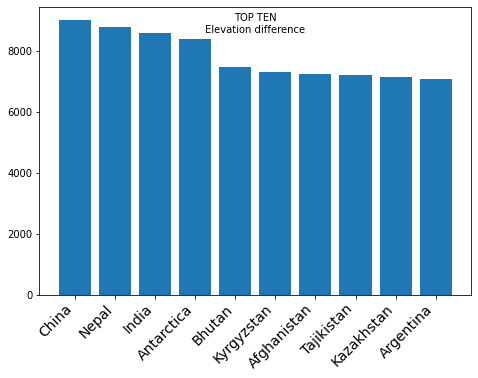

Elevation difference


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


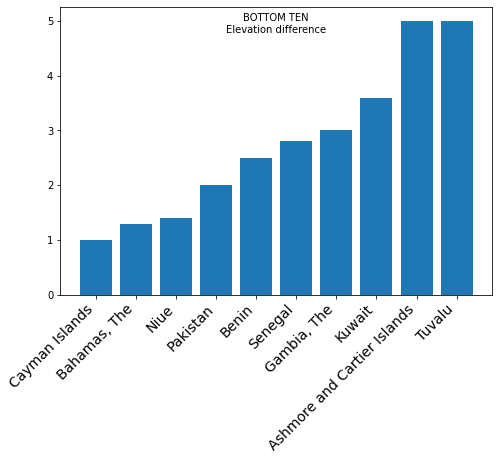

In [25]:
# countries with the largest difference between their lowest and highest point
# while the China-Nepal border dissects Siggamartha's summit, China itself has a 
#   lower minimum elevation than Nepal.
df[ 'Elevation difference' ] = (
    df[ 'Geography: Elevation - highest point' ] -
    df[ 'Geography: Elevation - lowest point' ])
showTopTen( 'Elevation difference', df )

# Flattest places in the world: no point on natural ground is at an ascent of 
#   more of than five meters from any other point.
showTopTen( 'Elevation difference', df, asc=True )

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


People and Society: Age structure - 65 years and over


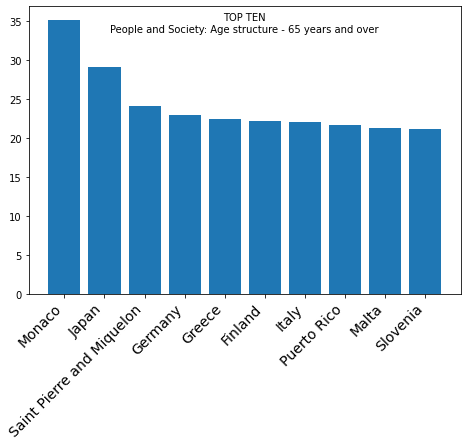

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


People and Society: Dependency ratios - potential support ratio


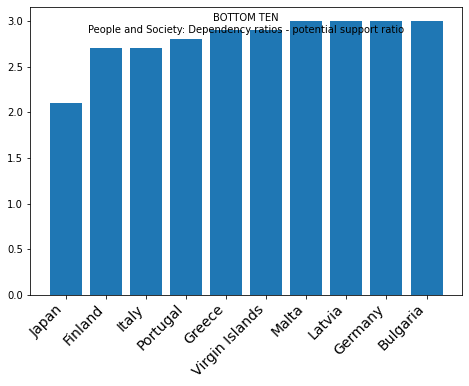

In [26]:
# highest percent of population in the 65+ bracket 
# Monaco and then Japan both stand conspicuously out from the distribution
# My speculation is that it would tend to be an older people who can afford 
#   Monaco's prestigious cost of living while, on the other hand, Japan has a 
#   culturally restrained birth rate - young adults tend to prioritize career 
#   ascension over family-making (cite).
showTopTen( 'People and Society: Age structure - 65 years and over', df )
# Japan takes the lead with % younger adults who might be able to 
#   take on a supporting role to the elderly, while Monaco, having more to
#   do the looking-after, is not in the bottom-ten for support ratio.
showTopTen( 'People and Society: Dependency ratios - potential support ratio', df, asc=True )

Irrigated-area ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


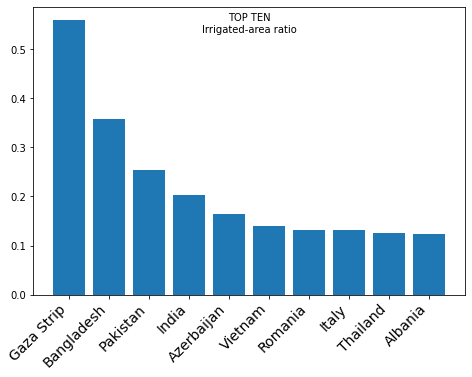

0.5583333333333333

In [27]:
# Ratio of irrigated land to total land
df[ 'Irrigated-area ratio' ] = (
    df[ 'Geography: Irrigated land' ] /
    df[ 'Geography: Area - total' ])
showTopTen( 'Irrigated-area ratio', df )
# Not surprised about most of the t10, who largely have a pastoral image,
#   but the Gaza Strip strikes one as being either desert or concrete. 
#   Still can be mostly true - Gaza as leader is still under 0.6%; an easy
#   threshold to reach given its small proportions.
df.loc[ df[ 'Country' ] == 'Gaza Strip', 'Irrigated-area ratio' ].iloc[ 0 ]
#   Some reading on esyrt in Palestinian agriculture: 
#       https://socialsciences.mcmaster.ca/kubursi/ebooks/water.htm

People and Society: Population growth rate


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


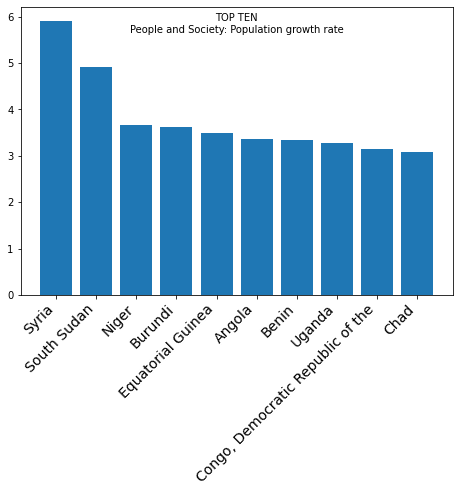

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


People and Society: Net migration rate


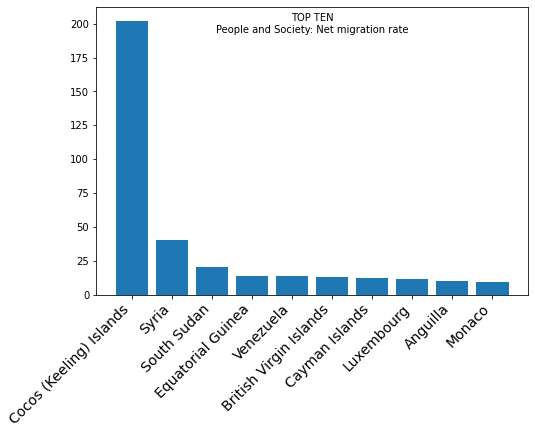

People and Society: Net migration rate


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


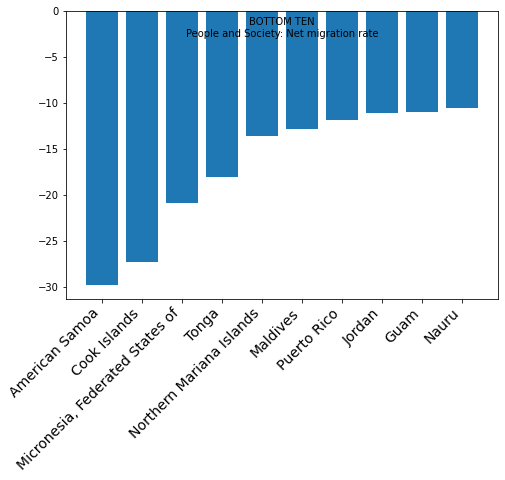

People and Society: Population growth rate


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


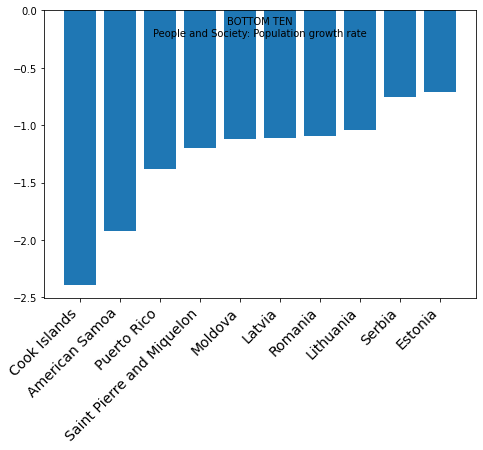

In [28]:
# Syria's far advancement in population growth must be linked to its even 
# greater leadership in net migration. What's the story there?
# (once the Cocos is excluded as an outlier. Also what's the story? 
#   In other sources the pop has not seemingly changed by anything like 100%)
showTopTen( 'People and Society: Population growth rate', df )
showTopTen( 'People and Society: Net migration rate', df )

# Most emmigration, and populations in greatest contraction
# two very strong categories: either islands, or eastern Europe.
# (Jordan being the one exception)
showTopTen( 'People and Society: Net migration rate', df, asc=True )
showTopTen( 'People and Society: Population growth rate', df, asc=True )

People and Society: Sex ratio - 25-54 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


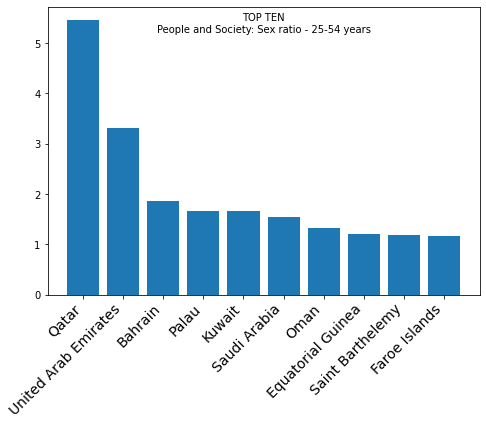

People and Society: Sex ratio - 55-64 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


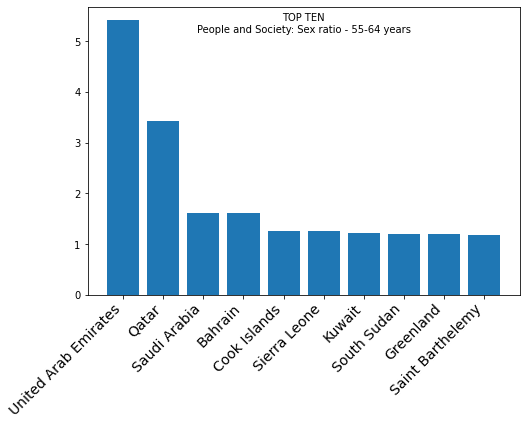

People and Society: Age structure - 25-54 years


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


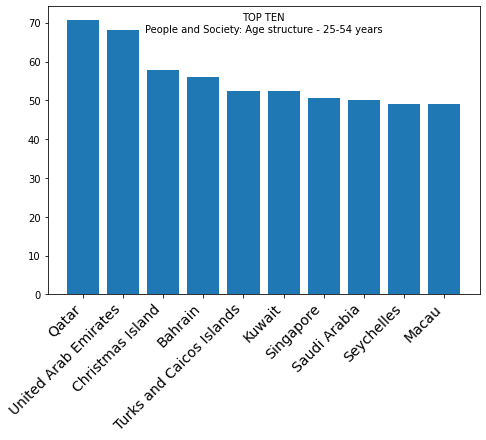

People and Society: Dependency ratios - potential support ratio


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


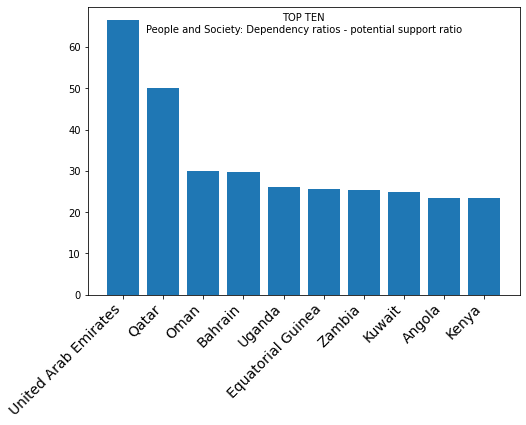

People and Society: Sex ratio - 65 years and over


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


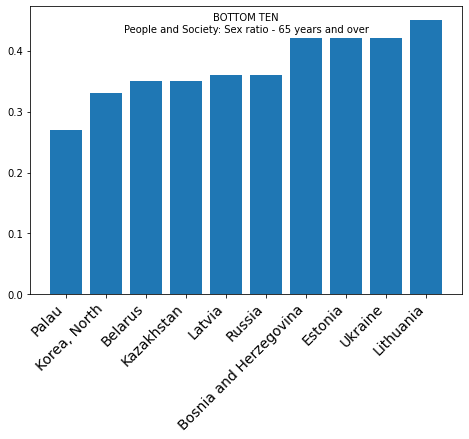

In [29]:
# Qatar & UAE's men-to-women ratios in the 25-54yo, 55-64yo and 65+ brackets 
# are startlingly weighted to men, the strongest in the world.
showTopTen( 'People and Society: Sex ratio - 25-54 years', df )
showTopTen( 'People and Society: Sex ratio - 55-64 years', df )
# At the same time, both have (by good measure) the highest value for
# the percentage of total population that is 25-54 years old.
showTopTen( 'People and Society: Age structure - 25-54 years', df )
# Interesting combination - purely speculating, one can imagine a dominating
# social discourse might concern the relation of older men to working-age adults.
# This consideration is furnished with the dependency ratio, in which
# UAE and Qatar are by very, very far the the world chart-toppers:
showTopTen( 'People and Society: Dependency ratios - potential support ratio', df )
# (What is the DR, and how would these three figures relate?)


# meanwhile, in Palau and North Korea, in the 65+ bracket, there are more than 
# twice as many ladies as gents.
showTopTen( 'People and Society: Sex ratio - 65 years and over', df, asc=True )


People and Society: Current Health Expenditure


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


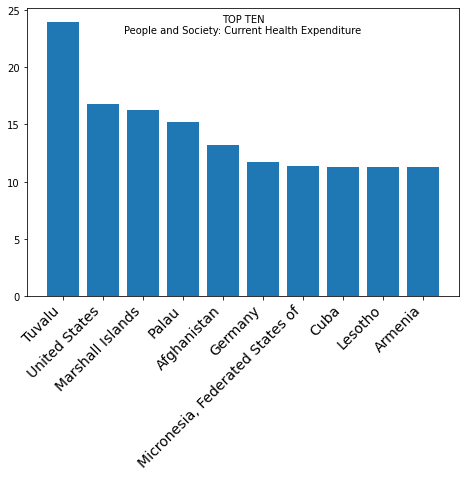

People and Society: Physicians density


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


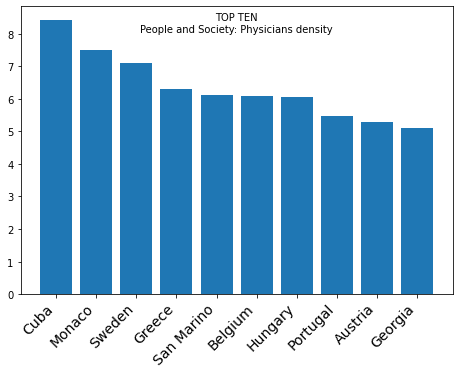

People and Society: Current Health Expenditure


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


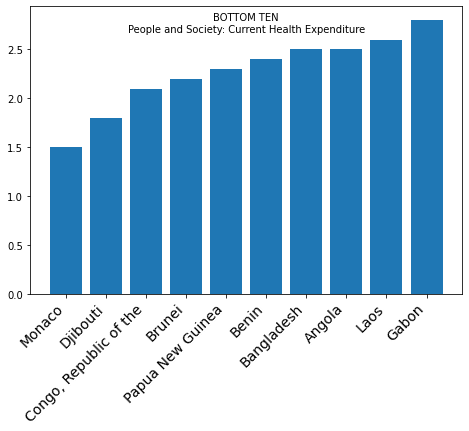

In [30]:
# People and Society: Current Health Expenditure
# Surprised to see US near the top with the impression given by private health 
# costs.
showTopTen( 'People and Society: Current Health Expenditure', df )
# Only one country in t10 expenditure is also in t10 physician density (Cuba)
showTopTen( 'People and Society: Physicians density', df )
# physician density strikes me as vital, as a population's relationship with
#   health-seeking, at a preventative stage, [is tied] to its familiarity and 
#   access to responsive human consultation.
# Nice littel one-liner aside: Cuba provides more medical personnel to the 
#   developing world than all the G8 countries combined.

# The only "first-world" country in bottom-10 health expenditure, indeed
#   leading the world, is Monaco, which happens also to:
#       - top the "% pop is 65+"
#       - have the second-highest physician density
# So, with such an old population and such a high density of physicians, 
#   it may be safe to assume that it is a great destination for 
#   private medical enterprise - if you can get in!
showTopTen( 'People and Society: Current Health Expenditure', df, asc=True )

People living with HIV/AIDs as percentage of population


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


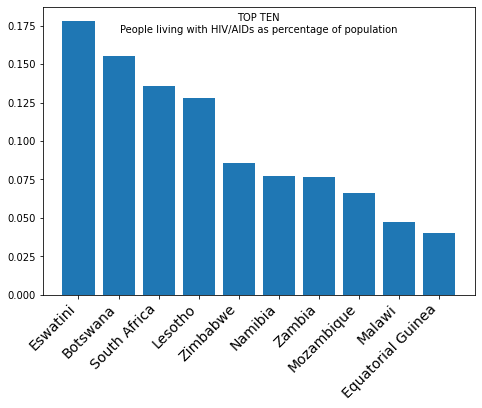

People living with HIV/AIDs as percentage of population


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


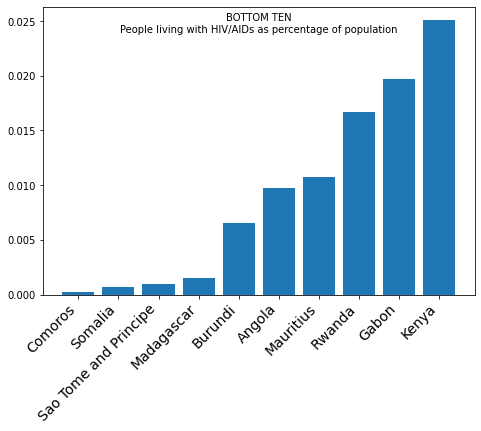

In [31]:
# Southern Africa nations exclusively form t10 %pop with HIV-AIDs.
df[ 'People living with HIV/AIDs as percentage of population' ] = (
    df[ 'People and Society: HIV/AIDS - people living with HIV/AIDS' ] / df[ 'People and Society: Population' ])
showTopTen( 'People living with HIV/AIDs as percentage of population', df )

# one becomes curious which SA nation has the lowest population with HIV/AIDs

sthEquatAfrica = [
    'Angola',
    'Botswana',
    'Burundi',
    'Comoros',
    'DR Congo',
    'Equatorial Guinea',
    'Eswatini',
    'Gabon',
    'Kenya',
    'Lesotho',
    'Madagascar',
    'Malawi',
    'Mauritius',
    'Mozambique',
    'Namibia',
    'Republic of the Congo',
    'Rwanda',
    'Sao Tome and Principe',
    'Seychelles',
    'Somalia',
    'South Africa',
    'Tanzania',
    'Uganda',
    'Zambia',
    'Zimbabwe' ]

showTopTen( 'People living with HIV/AIDs as percentage of population',
    df[ df[ 'Country' ].isin( sthEquatAfrica ) ], asc=True )

# For the countries that are not islands, Somalia and Burundi appear to 
#   practice the most effective prevention

People and Society: Tobacco use - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


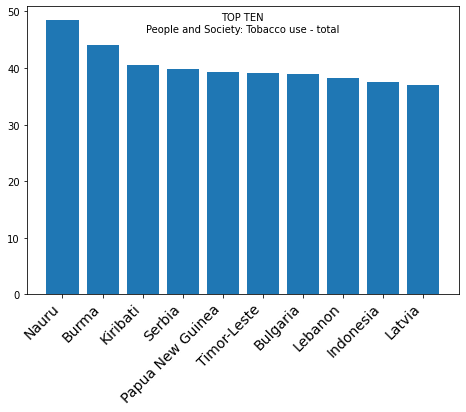

People and Society: Tobacco use - male


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


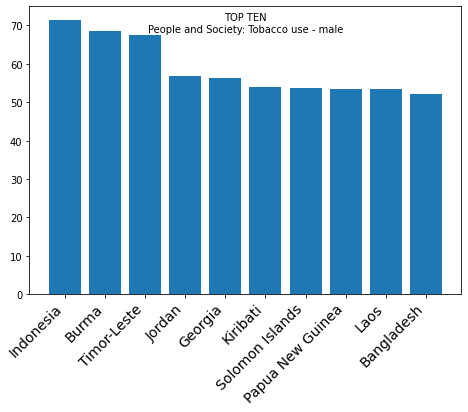

People and Society: Tobacco use - female


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


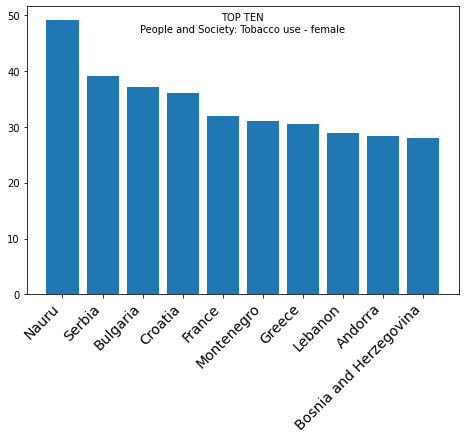

People and Society: Tobacco use - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


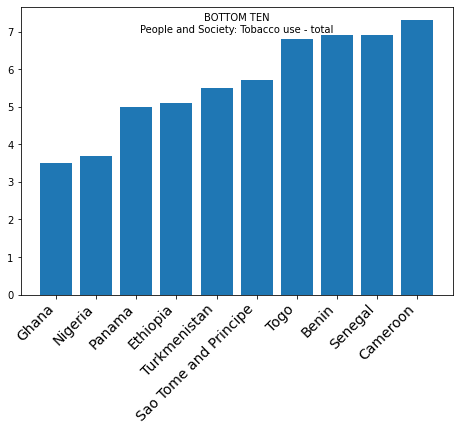

In [32]:
# Nearly half the people in Nauru and Burma smoke
showTopTen( 'People and Society: Tobacco use - total', df )
# However, when limited to females, whereas European nations remain in the t10,
# the Asia-Pacific nations Burma, Kiribati, Timor Leste, PNG and Indonesia 
# disappear ( whereas for men they remain).  
#   - Gender associations with the act of smoking? 
#     (eg.: "smoking is manly (positive) and/or unwomanly (negative)"

# Pattern strikingly reversed for Nauru (#1 t10:total/women, not in t10:men).
showTopTen( 'People and Society: Tobacco use - male', df )
showTopTen( 'People and Society: Tobacco use - female', df )

# Smokers don't go here anymore: Some surprises given my assumed vague
#   association of lower-GDP with a higher smoking rate
showTopTen( 'People and Society: Tobacco use - total', df, asc=True )


People and Society: Children under the age of 5 years underweight


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


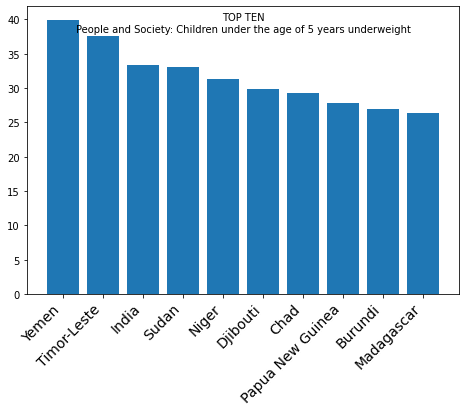

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


People and Society: Obesity - adult prevalence rate


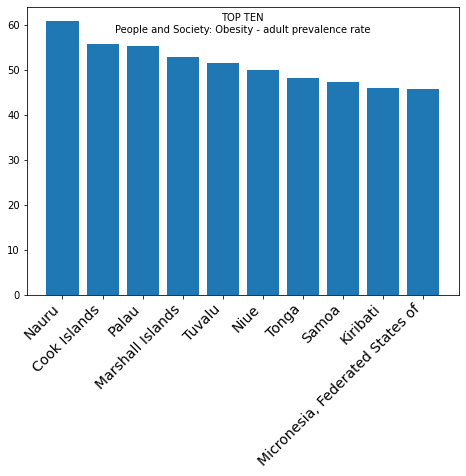

Generational weight disparity


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


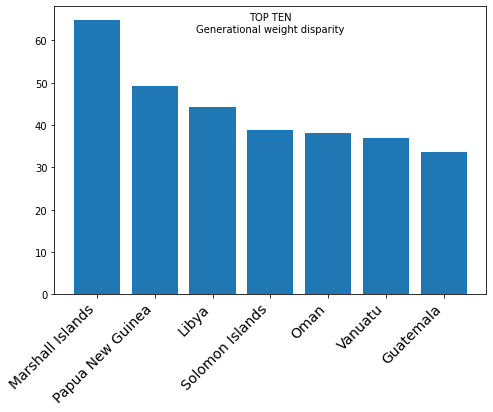

In [33]:
# who has the highest combined score for both adult obesity prevalence and 
# children 4- underweight, where both scores are above feature mean?

uFeat = 'People and Society: Children under the age of 5 years underweight'
oFeat = 'People and Society: Obesity - adult prevalence rate'

showTopTen( uFeat, df )
showTopTen( oFeat, df )

df[ 'Generational weight disparity' ] = (df[ uFeat ] + df[ oFeat ])

aboveMeans = [ country for country in df[ 'Country' ] if (
    df.loc[ df[ 'Country' ] == country, uFeat ].iloc[ 0 ]
    >=df[ uFeat ].mean() and
    df.loc[ df[ 'Country' ] == country, oFeat ].iloc[ 0 ]
    >=df[ oFeat ].mean()) ]

showTopTen( 'Generational weight disparity',
    df[ df[ 'Country' ].isin( aboveMeans ) ] )

People and Society: School life expectancy (primary to tertiary education) - total


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


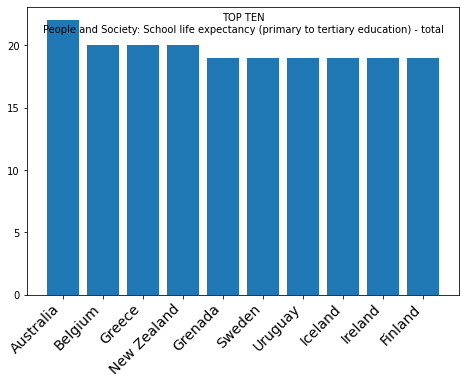

People and Society: School life expectancy (primary to tertiary education) - male


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


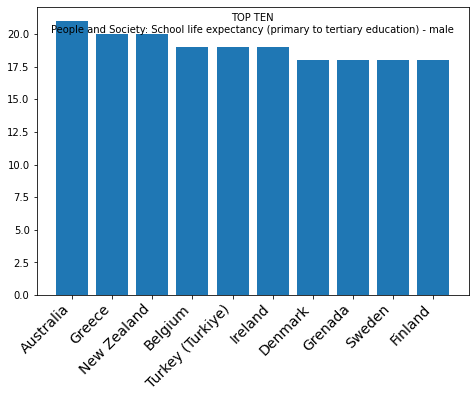

People and Society: School life expectancy (primary to tertiary education) - female


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


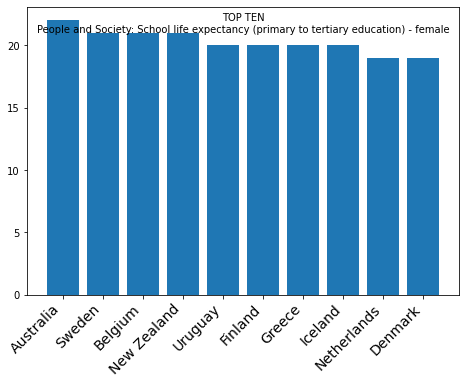

In [34]:
# EDUCATION DISPARITIES:
expectFeatStr = (
    "People and Society: School life expectancy (primary to tertiary "
    "education)")
showTopTen( f'{expectFeatStr} - total', df )
showTopTen( f'{expectFeatStr} - male', df )
showTopTen( f'{expectFeatStr} - female',
    df[ df[ 'Country' ] != f'Turks and Caicos Islands' ] )
# Excluding outlier "Turks and Caicos islands" (reported with a truly impressive 
# ~200-year school life expectency for females. Now that's a quality education): 

# Pat on the back for Aus: by a modest yet significant margin, has the longest
#   total percent competing teriary, AND the position holds true for women as 
#   much as men.

Environment: Land use - forest


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


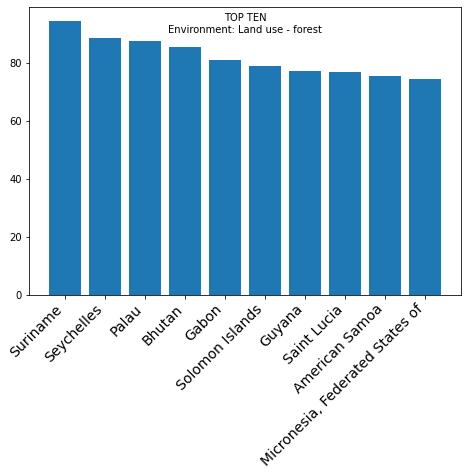

With value of [ 2.36 ], Suriname is 174th-highest for:
'Environment: Revenue from forest resources - forest revenues'
(total ranked records: 258)


In [35]:

# A pleasant pit-stop in the forests of Suriname:
showTopTen( 'Environment: Land use - forest', df )


# interestingly, Suriname does very little to leverage this as a resource 
#   advantage - Suriname's rank in %rev Forst rsrc is...

def getRank( _df, country, feature ):
    val = _df[ feature ].loc[ _df[ 'Country' ] == country ].values[ 0 ]
    rank = len( [ v for v in pd.Series( _df[ feature ] ) if v<val ] )
    print( f"With value of [ {val} ], {country} is {rank}th-highest for:\n"
           f"'{feature}'\n(total ranked records: {len( cleanCountries )})" )
 
getRank( df, 'Suriname', 
    'Environment: Revenue from forest resources - forest revenues' )


Environment: Urbanization - urban population


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


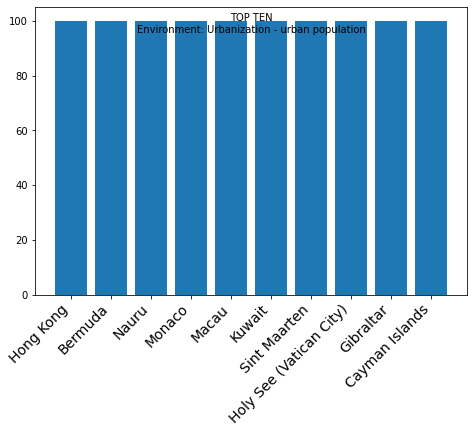

Environment: Urbanization - urban population


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


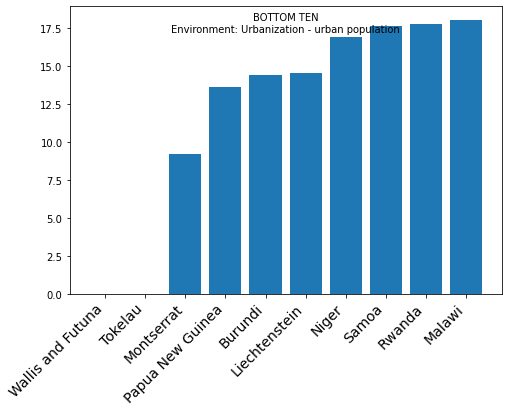

In [36]:
# 
#   Fairly even, City-States understandably dominating the top 10. 
showTopTen( 'Environment: Urbanization - urban population', df )
showTopTen( 'Environment: Urbanization - urban population', df, asc=True )

# Of the least-urbanised, several are pacific territories with relatively 
#   unfamiliar names: Wallis and Futuna (FR), Montserrat (UK) and Tokelau (NZ). 
#   To help with attribution, if not decolonization, I submit that the UK and 
#   French territories swap names.
# Liechtenstein... is also there.

# Get this group ordered by population


In [37]:
# COAL
# Environment: Revenue from coal - coal revenues
#   Presumably %GDR; while most of the top 10 is quite flat, the top three
#       each tower around twice as high above the previous value, 
#       with mongolia leading by far as having highest coal-rev. %GDR

# 
# Not a glitch: China's appetite
# Energy: Coal - Production
# Just for scale, this is what the production of the top-ten coal producers 
# looks like. More astonishingly, China remains a net importer - they consume 
# this and more. The equivalent plot for consumption looks the same, except the 
# names of the rest of the world are in a different order.
#
# Diving in to some more figures:
# 
# dfCoalPnC = dffBook.loc[ :, [ 'Country',
#                                 'Energy: Coal - Production',
#                                 'Energy: Coal - Consumption' ] ]
# 
# dfChina = dfCoalPnC[ dfCoalPnC.Country == 'China' ]
# chinaProd = dfChina.iloc[ :, 1 ].sum()
# chinaCsmp = dfChina.iloc[ :, 2 ].sum()
# 
# dfNotChina = dfCoalPnC[ dfCoalPnC.Country != 'China' ]
# notChinaProd = dfNotChina.iloc[ :, 1 ].sum()
# notChinaCsmp = dfNotChina.iloc[ :, 2 ].sum()
# 
# pad = (max( [ len( str( i ) )
#     for i in [ chinaProd, notChinaProd, chinaCsmp, notChinaCsmp ] ] ))
# productReport = (f"PRODUCTION: China's production is "
#                  f"[ {(chinaProd / notChinaProd):,.2f} ] times larger\n"
#                  f"   [ {chinaProd:>{pad},.2f} ]: China's coal production\n"
#                  f"   [ {notChinaProd:>{pad},.2f} ]: rest of world combined\n")
# consmptReport = (f"CONSUMPTION: China's consumption is "
#                  f"[ {(chinaCsmp / notChinaCsmp):,.2f} ] times larger\n"
#                  f"   [ {chinaCsmp:>{pad},.2f} ]: China's coal consumption\n"
#                  f"   [ {notChinaCsmp:>{pad},.2f} ]: rest of world combined\n")
# 
# print( productReport, consmptReport )

# Environment: Air pollutants - carbon dioxide emissions
#   China leads by twice its nearest competitor, the US. See coal-relation (hah)
# Similar stats for Environment: Air pollutants - methane emission.


In [38]:
listStart = 79
showNumber = 2

79:81
Environment: Waste and recycling - municipal solid waste generated annually


C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


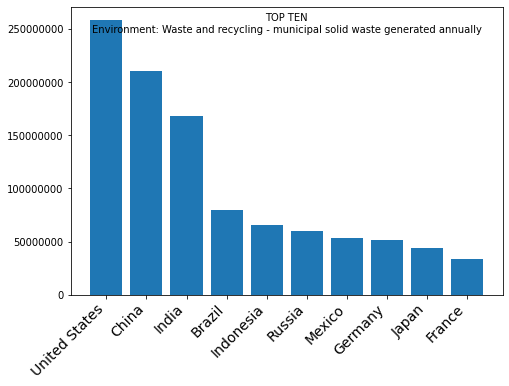

C:\Users\ROMSTR~1\AppData\Local\Temp/ipykernel_2388/3193909875.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels=df10.iloc[ :, 0 ], rotation=45, ha='right' )


Environment: Total water withdrawal - municipal


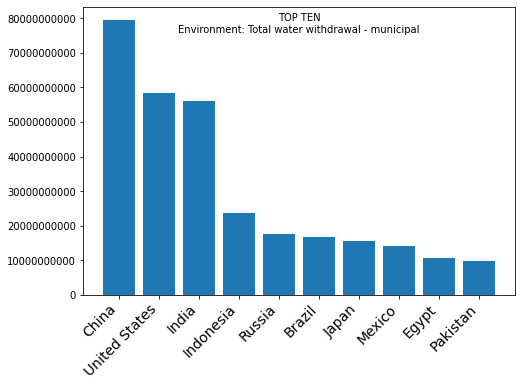

In [39]:
print( f"{listStart}:{listStart + showNumber}" )
for i in list( df.columns )[ listStart:listStart + showNumber ]: 
    showTopTen( i, df )
    listStart += showNumber

newDrops = [
    'Government: Country name - etymology',
    'Economy: Real GDP per capita - note'
    
    ]

In [40]:
# Things that China is in the top-ten/5/3/1 of
# (Who else are the "most top 10/5/3/1" countries?)
# combine bottom-tens somehow?

In [41]:
# Generate CORRELATION DICTIONARY where keys are correlations,
#   values are key-value pairs of baseCol : compareDict
#   CompareDict key-value is col num : correlation coefficient

# correlDict = { }
# baseCol = 1
# while True:
#     colCorrs = { }
#     for colPos in range( baseCol + 1, df.shape[ 1 ] ):
#         colCorrs[ colPos ] = df.iloc[ :, baseCol ].corr( df.iloc[ :, colPos ] )
#     correlDict[ baseCol ] = colCorrs
#     baseCol += 1
#     if baseCol == df.shape[ 1 ]: print( f"Completed correlations" ); break
# 


In [42]:
# move all most defs to import module, except where useful for process 
# communication
# Heh. mosdef.

# END